     n      side  score_contrib  min_side  efficiency       gap
0    1  0.813173       0.661250  0.495606    0.371456  0.317567
1    2  0.949504       0.450779  0.700892    0.544890  0.248612
2    3  1.142031       0.434745  0.858414    0.564986  0.283617
4    5  1.443692       0.416850  1.108208    0.589241  0.335484
3    4  1.290806       0.416545  0.991211    0.589672  0.299594
6    7  1.673104       0.399897  1.311249    0.614221  0.361854
5    6  1.548438       0.399610  1.213981    0.614661  0.334457
8    9  1.867280       0.387415  1.486817    0.634010  0.380463
7    8  1.755921       0.385407  1.401785    0.637313  0.354136
14  15  2.384962       0.379203  1.919473    0.647740  0.465489
     n      side  score_contrib  min_side  efficiency       gap
0    1  0.813173       0.661250  0.495606    0.371456  0.317567
1    2  0.949504       0.450779  0.700892    0.544890  0.248612
2    3  1.142031       0.434745  0.858414    0.564986  0.283617
4    5  1.443692       0.416850  1.10820

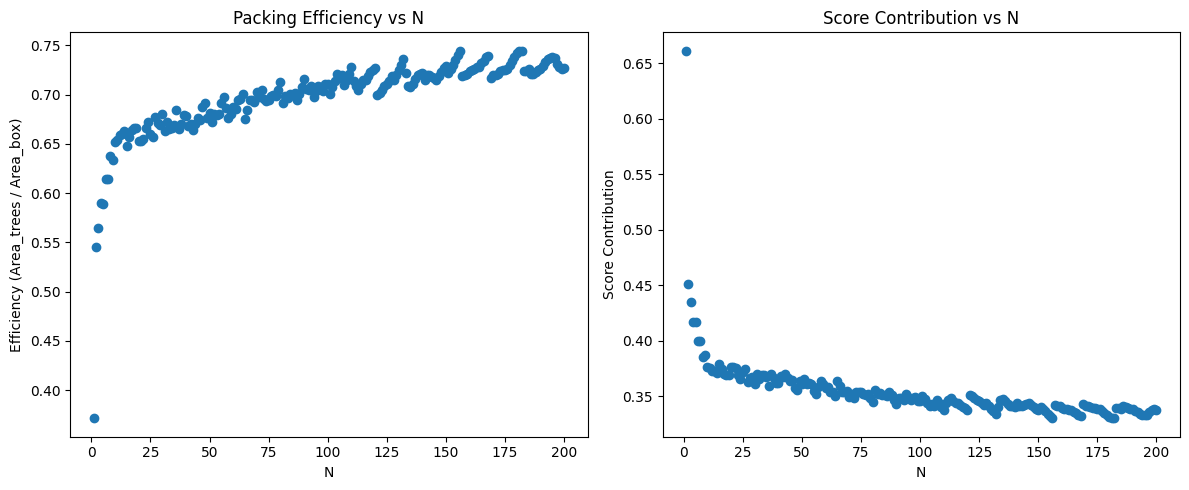

In [1]:
import pandas as pd
import numpy as np
from decimal import Decimal, getcontext
from shapely import affinity
from shapely.geometry import Polygon
from shapely.ops import unary_union
import matplotlib.pyplot as plt
import seaborn as sns

# Set precision
getcontext().prec = 30
scale_factor = Decimal("1")

class ChristmasTree:
    def __init__(self, center_x="0", center_y="0", angle="0"):
        self.center_x = Decimal(str(center_x))
        self.center_y = Decimal(str(center_y))
        self.angle = Decimal(str(angle))

        trunk_w = Decimal("0.15")
        trunk_h = Decimal("0.2")
        base_w = Decimal("0.7")
        mid_w  = Decimal("0.4")
        top_w  = Decimal("0.25")
        tip_y = Decimal("0.8")
        tier_1_y = Decimal("0.5")
        tier_2_y = Decimal("0.25")
        base_y = Decimal("0.0")
        trunk_bottom_y = -trunk_h

        initial_polygon = Polygon(
            [
                (Decimal("0.0") * scale_factor, tip_y * scale_factor),
                (top_w / Decimal("2") * scale_factor, tier_1_y * scale_factor),
                (top_w / Decimal("4") * scale_factor, tier_1_y * scale_factor),
                (mid_w / Decimal("2") * scale_factor, tier_2_y * scale_factor),
                (mid_w / Decimal("4") * scale_factor, tier_2_y * scale_factor),
                (base_w / Decimal("2") * scale_factor, base_y * scale_factor),
                (trunk_w / Decimal("2") * scale_factor, base_y * scale_factor),
                (trunk_w / Decimal("2") * scale_factor, trunk_bottom_y * scale_factor),
                (-(trunk_w / Decimal("2")) * scale_factor, trunk_bottom_y * scale_factor),
                (-(trunk_w / Decimal("2")) * scale_factor, base_y * scale_factor),
                (-(base_w / Decimal("2")) * scale_factor, base_y * scale_factor),
                (-(mid_w / Decimal("4")) * scale_factor, tier_2_y * scale_factor),
                (-(mid_w / Decimal("2")) * scale_factor, tier_2_y * scale_factor),
                (-(top_w / Decimal("4")) * scale_factor, tier_1_y * scale_factor),
                (-(top_w / Decimal("2")) * scale_factor, tier_1_y * scale_factor),
            ]
        )

        rotated = affinity.rotate(initial_polygon, float(self.angle), origin=(0, 0))
        self.polygon = affinity.translate(
            rotated,
            xoff=float(self.center_x * scale_factor),
            yoff=float(self.center_y * scale_factor),
        )

def parse_csv(csv_path):
    df = pd.read_csv(csv_path)
    df["x"] = df["x"].astype(str).str.strip().str.lstrip("s")
    df["y"] = df["y"].astype(str).str.strip().str.lstrip("s")
    df["deg"] = df["deg"].astype(str).str.strip().str.lstrip("s")
    df[["group_id", "item_id"]] = df["id"].str.split("_", n=2, expand=True)
    
    dict_of_tree_list = {}
    for group_id, group_data in df.groupby("group_id"):
        tree_list = [
            ChristmasTree(center_x=row["x"], center_y=row["y"], angle=row["deg"])
            for _, row in group_data.iterrows()
        ]
        dict_of_tree_list[int(group_id)] = tree_list
    return dict_of_tree_list

def get_score_components(csv_path):
    tree_dict = parse_csv(csv_path)
    results = []
    
    # Calculate area of one tree
    t = ChristmasTree()
    tree_area = t.polygon.area
    
    for n, trees in tree_dict.items():
        all_polygons = [t.polygon for t in trees]
        bounds = unary_union(all_polygons).bounds
        width = bounds[2] - bounds[0]
        height = bounds[3] - bounds[1]
        side = max(width, height)
        
        score_contrib = (side ** 2) / n
        
        # Theoretical min side (if perfect packing with no gaps)
        # Total area = n * tree_area
        # Min side = sqrt(Total area)
        min_side = np.sqrt(n * tree_area)
        efficiency = (n * tree_area) / (side ** 2)
        
        results.append({
            "n": n,
            "side": side,
            "score_contrib": score_contrib,
            "min_side": min_side,
            "efficiency": efficiency,
            "gap": side - min_side
        })
        
    return pd.DataFrame(results)

df = get_score_components("submission.csv")
print(df.sort_values("efficiency").head(10))
print(df.sort_values("score_contrib", ascending=False).head(10))

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(df["n"], df["efficiency"])
plt.title("Packing Efficiency vs N")
plt.xlabel("N")
plt.ylabel("Efficiency (Area_trees / Area_box)")

plt.subplot(1, 2, 2)
plt.scatter(df["n"], df["score_contrib"])
plt.title("Score Contribution vs N")
plt.xlabel("N")
plt.ylabel("Score Contribution")
plt.tight_layout()
plt.savefig("efficiency_analysis.png")
